In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from datasets import load_dataset
from transformers import AutoTokenizer, Trainer, AutoModelForSequenceClassification, TrainingArguments
from torchinfo import summary

from transformers import pipeline

In [30]:
df_ = pd.read_csv("data/AirlineTweet.csv")

In [3]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df = df_[["airline_sentiment", "text"]]

<Axes: >

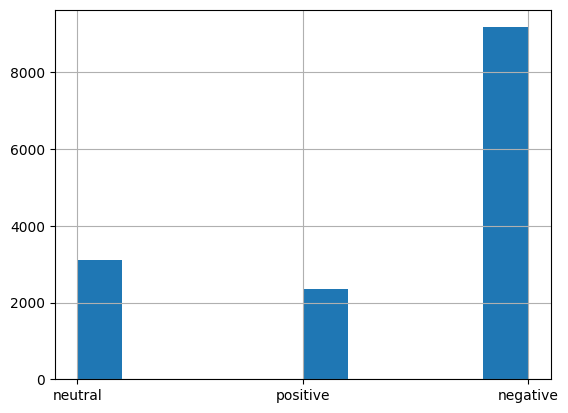

In [5]:
df["airline_sentiment"].hist()

In [8]:
target_map = {"positive": 1, "negative":0, "neutral":2}
df["target"] = df["airline_sentiment"].map(target_map)

C:\Users\emili\AppData\Local\Temp\ipykernel_17924\1741190650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["airline_sentiment"].map(target_map)


In [9]:
df

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,0
14637,neutral,@AmericanAir Please bring American Airlines to...,2
14638,negative,"@AmericanAir you have my money, you change my ...",0


In [11]:
df2 = df[["text", "target"]]
# ATTENZIONE: il nostro target DEVE avere la colonna chiamata "label" per funzionare correttamente!!
# Non vale lo stesso per l'input, in quanto flessibile
df2.columns = ["sentence", "label"]
df2.to_csv("data/Airline_preprocessed.csv", index=None)

In [14]:
raw_dataset = load_dataset("csv", data_files="data/Airline_preprocessed.csv")

Generating train split: 14640 examples [00:00, 240178.87 examples/s]


In [15]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [16]:
# Il dataset ha un metodo suo che è train_test_split simile a sklearn
split = raw_dataset["train"].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [18]:
"""
Casi particolari
1. Abbiamo più csv da caricare: 
    load_dataset("csv", data_files= ["csv1.csv", "csv2.csv", "csv3.csv"])
Però in questo caso mettiamo tutto nel dataset di train

OPPURE
2. Abbiamo già il train test split!
    load_dataset("csv", data_files= {train :["train1.csv", "train2.csv"], "test": "test.csv"})

""";

In [19]:
checkpoint = "distilbert-base-cased"

In [24]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

C:\Users\emili\Desktop\transformers_course\transformers-env\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
# Perchè non mettiamo il padding? Se lo gestisce il trainer
def tokenize_fn(batch):
    return tokenizer(batch["sentence"], truncation=True)

In [26]:
tokenized_dataset = split.map(tokenize_fn, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████| 4392/4392 [00:00<00:00, 7124.01 examples/s]


In [27]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [33]:
# Specifichiamo la batch size usata PER DISPOSITIVO
training_args = TrainingArguments(
    output_dir="sentiment_analysis_custom_training",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64 
)

In [37]:
"""
A differenza dei dataset di prova, dove abbiamo delle metriche, qui non abbiamo alcuna metrica di base.
Quello che sappiamo, però è cosa ritornano: un DIZIONARIO con key il nome della metrica e valore il valore di riferimento.
"""
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average="macro")
    return {"Accuracy": acc, "f1": f1}

In [39]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
    

In [40]:
# Post training ci rendiamo conto effettivamente che il secondo checkpoint è quello che minimizza sia train che validation loss
# Prenderemo quello
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.544200,0.464165,0.824226,0.759957
2,0.344500,0.482646,0.833789,0.770553
3,0.241200,0.612958,0.833106,0.780183


TrainOutput(global_step=1923, training_loss=0.3279938005991919, metrics={'train_runtime': 200.1458, 'train_samples_per_second': 153.608, 'train_steps_per_second': 9.608, 'total_flos': 388537948763424.0, 'train_loss': 0.3279938005991919, 'epoch': 3.0})

In [44]:
# carichiamo la nostra pipeline prendendo il modello alla seconda epoch
classifier = pipeline("text-classification", 
                      model="sentiment_analysis_custom_training/checkpoint-1282/",
                     device=0)

In [45]:
split["test"]

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [47]:
test_predictions = classifier(split["test"]["sentence"])

In [48]:
test_predictions

[{'label': 'LABEL_1', 'score': 0.9410637021064758},
 {'label': 'LABEL_1', 'score': 0.9250034093856812},
 {'label': 'LABEL_0', 'score': 0.4968067705631256},
 {'label': 'LABEL_1', 'score': 0.6872050166130066},
 {'label': 'LABEL_2', 'score': 0.4102849066257477},
 {'label': 'LABEL_0', 'score': 0.9960921406745911},
 {'label': 'LABEL_2', 'score': 0.8910524249076843},
 {'label': 'LABEL_0', 'score': 0.9124829173088074},
 {'label': 'LABEL_1', 'score': 0.7618339657783508},
 {'label': 'LABEL_0', 'score': 0.9975183010101318},
 {'label': 'LABEL_0', 'score': 0.9686822295188904},
 {'label': 'LABEL_0', 'score': 0.9949489831924438},
 {'label': 'LABEL_1', 'score': 0.9120328426361084},
 {'label': 'LABEL_0', 'score': 0.9946545362472534},
 {'label': 'LABEL_2', 'score': 0.9694287776947021},
 {'label': 'LABEL_1', 'score': 0.4540572464466095},
 {'label': 'LABEL_1', 'score': 0.8074675798416138},
 {'label': 'LABEL_0', 'score': 0.9973664879798889},
 {'label': 'LABEL_0', 'score': 0.855872392654419},
 {'label': 'L

In [49]:
def get_label(d):
    return int(d["label"].split("_")[-1])

In [50]:
pred_labels = [get_label(d) for d in test_predictions]

In [53]:
print("Accuracy: ", accuracy_score(pred_labels, split["test"]["label"]))

Accuracy:  0.8337887067395264


In [56]:
print("F1: ", f1_score(split["test"]["label"], pred_labels,  average="macro"))

F1:  0.770553033297773


In [57]:
def plot_confusion(cm):
    classes = ["negative", "positive", "neutral"]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt="g")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")


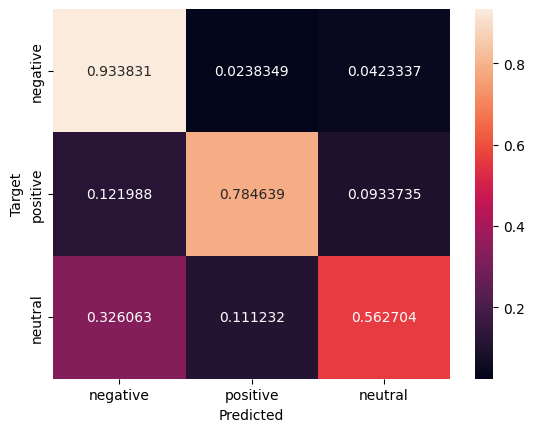

In [61]:
cm = confusion_matrix(split["test"]["label"], pred_labels, normalize="true")
plot_confusion(cm)